In [ ]:
import torch
from string import punctuation
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.lm import Vocabulary
from nltk import pos_tag
import pandas as pd
import numpy as np
import string
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import spacy

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

spacy.load('en_core_web_sm')

!unzip liar_dataset.zip
dataset_columns = ['id','label','text','subject','speaker','job title','state info','party','barely true','false','half true','mostly true','pants on fire','context']
train = pd.read_csv('train.tsv',sep='\t',header=None, names = dataset_columns)
test = pd.read_csv('test.tsv',sep='\t',header=None, names = dataset_columns)
val = pd.read_csv('valid.tsv',sep='\t',header=None, names = dataset_columns)

def handle_nas(df):
  # get all indices where job title and state info are nas:
  jt_indices = df[df["job title"].isna()].index
  si_indices = df[df["state info"].isna()].index

  df.loc[jt_indices,"job title"] = "unk"
  df.loc[si_indices,"state info"] = "unk"

  # dropping all other rows with nas
  df['text'] = df['text'].replace('', pd.NA)
  df.dropna(inplace=True)
  df = df.reset_index(drop=True)

  return df

train = handle_nas(train)
test = handle_nas(test)
val = handle_nas(val)

def get_meta_data(df, df_val, df_test):
  concatenated_df = pd.concat([df,df_val,df_test])
  print(concatenated_df)
  # handling meta data
  # not storing anything in vocab
  top_categories = df['speaker'].value_counts().nlargest(20).index
  print("speaker top categories:",df['speaker'].value_counts().nlargest(20))
  concatenated_df['speaker'] = concatenated_df['speaker'].where(concatenated_df['speaker'].isin(top_categories), 'Other')
  speaker_ohe = pd.get_dummies(concatenated_df['speaker']).to_numpy()
  print(speaker_ohe.shape)

  # largest category is unk which we imputed. To ensure there is no bias, it is
  # not taken into consideration
  top_categories = df['job title'].value_counts().nlargest(21)[1:].index
  print("job title top categories:",df['job title'].value_counts().nlargest(21))
  concatenated_df['job title'] = concatenated_df['job title'].where(concatenated_df['job title'].isin(top_categories), 'Other')
  job_title_ohe = pd.get_dummies(concatenated_df['job title']).to_numpy()
  print(job_title_ohe.shape)

  # largest category is unk which we imputed. To ensure there is no bias, it is
  # not taken into consideration
  top_categories = df['state info'].value_counts().nlargest(21)[1:].index
  print("state info top categories:",df['state info'].value_counts().nlargest(21))
  concatenated_df['state info'] = concatenated_df['state info'].where(concatenated_df['state info'].isin(top_categories), 'Other')
  state_info_ohe = pd.get_dummies(concatenated_df['state info']).to_numpy()
  print(state_info_ohe.shape)

  top_categories = df['party'].value_counts().nlargest(20).index
  print("party top categories:",df['party'].value_counts().nlargest(20))
  concatenated_df['party'] = concatenated_df['party'].where(concatenated_df['party'].isin(top_categories), 'Other')
  party_ohe = pd.get_dummies(concatenated_df['party']).to_numpy()
  print(party_ohe.shape)


  top_categories = (
      df['subject'].str.split(',', expand=True).stack()
      .value_counts().nlargest(20).index
  )

  subjects = concatenated_df['subject'].apply(lambda x: [cat for cat in x.split(',') if cat in top_categories])
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)
  print("subjects top categories:",subjects.columns)
  subject_ohe = subjects.to_numpy()
  print(subject_ohe.shape)

  counts = concatenated_df[['barely true','false','half true','mostly true','pants on fire']].to_numpy()
  print(counts.shape)

  meta_data = np.hstack((speaker_ohe,job_title_ohe,state_info_ohe,party_ohe))
  meta_data_train = meta_data[:len(df)]
  meta_data_val = meta_data[len(df):len(df)+len(df_val)]
  meta_data_test = meta_data[len(df)+len(df_val):]
  print(meta_data.shape)

  return meta_data_train,meta_data_val,meta_data_test

meta_data_train,meta_data_val,meta_data_test = get_meta_data(train,val,test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Archive:  liar_dataset.zip
  inflating: README                  
  inflating: test.tsv                
  inflating: train.tsv               
  inflating: valid.tsv               
              id        label  \
0      2635.json        false   
1     10540.json    half-true   
2       324.json  mostly-true   
3      1123.json        false   
4      9028.json    half-true   
...          ...          ...   
1245   7334.json    half-true   
1246   9788.json  barely-true   
1247  10710.json  barely-true   
1248   3186.json  barely-true   
1249   6743.json        false   

                                                   text  \
0     Says the Annies List political group supports ...   
1     When did the decline of coal start? It started...   
2     Hillary Clinton agrees with John McCain "by vo...   
3     Health care reform legislation is likely to ma...   
4     The economic turnaround started at the end of ...   
...                                                 ...   
1245  Says 

<ipython-input-1-e0524abfa002>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)


subjects top categories: Index(['candidates-biography', 'crime', 'economy', 'education', 'elections',
       'energy', 'environment', 'federal-budget', 'foreign-policy', 'guns',
       'health-care', 'history', 'immigration', 'job-accomplishments', 'jobs',
       'legal-issues', 'military', 'state-budget', 'taxes', 'workers'],
      dtype='object')
(8305, 20)
(12660, 5)
(12660, 84)


<ipython-input-1-e0524abfa002>:102: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)


In [ ]:
train["label"].value_counts()

half-true      2097
false          1972
mostly-true    1945
true           1656
barely-true    1640
pants-fire      828
Name: label, dtype: int64

In [ ]:
meta_data_train.shape,meta_data_val.shape,meta_data_test.shape

((10138, 84), (1272, 84), (1250, 84))

In [ ]:

one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

class LiarDataset(torch.utils.data.Dataset):
  def __init__(self,data,meta_data,all_labels = False, vocab = None, POS_vocab = None, DEP_vocab = None, build_vocab = True):
    self.data = data
    self.all_labels = all_labels
    # get labels
    if self.all_labels == True:
      label_encoder = LabelEncoder()
      self.labels = label_encoder.fit_transform(self.data["label"])
    else:
      self.data["label"] = self.data["label"].replace(['half-true', 'mostly-true', 'true'], 'true')
      self.data["label"] = self.data["label"].replace(['false', 'barely-true', 'pants-fire'], 'false')
      label_encoder = LabelEncoder()
      self.labels = label_encoder.fit_transform(self.data["label"])

    self.stopwords = nltk.corpus.stopwords.words("english")
    self.lemmatizer = nltk.stem.WordNetLemmatizer()
    self.vocab = vocab
    self.POS_vocab = POS_vocab
    self.build_vocab = build_vocab
    self.nlp = spacy.load("en_core_web_sm")
    self.tokenizer = get_tokenizer('basic_english')
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.max_len = 18
    self.meta_data = meta_data

  def __getitem__(self,idx):
    s = self.data["text"][idx]
    s = s.lower()
    s = ''.join([c for c in s if c not in string.punctuation])
    # tokenize text
    s = nltk.word_tokenize(s)
    # remove stop words
    s = [word for word in s if word not in self.stopwords]
    pos = pos_tag(s)
    pos = [tup[1] for tup in pos]
    # perform lemmatization
    s = [self.lemmatizer.lemmatize(word) for word in s]
    s = ' '.join(s)

    # handle meta data

    sample = {"Text":s,"POS":pos,"Meta":self.meta_data[idx],"Label":self.labels[idx]}
    if self.build_vocab == False:
      sample["Text"] = torch.tensor(self.vocab(self.tokenizer(sample["Text"])), dtype=torch.int)
      sample["POS"] = torch.tensor(self.POS_vocab(sample["POS"]), dtype=torch.int)
      sample["Meta"] = torch.tensor(sample["Meta"], dtype=torch.float)
      sample = self.preprocessing(sample)
    return sample

  def __len__(self):
    return len(self.data)

  def preprocessing(self,sample):
    if len(sample["Text"]) > self.max_len:
      sample["Text"] = sample["Text"][:self.max_len].to(torch.int)
      sample["POS"] = sample["POS"][:self.max_len].to(torch.int)
    else:
      sample["Text"] = torch.cat((sample["Text"],torch.tensor([0 for i in range(len(sample["Text"]),self.max_len)])), dim = 0).to(torch.int)
      sample["POS"] = torch.cat((sample["POS"],torch.tensor([0 for i in range(len(sample["POS"]),self.max_len)])), dim = 0).to(torch.int)

    for key in sample:
      if torch.is_tensor(sample[key]):
        sample[key] = sample[key]
      else:
        sample[key] = torch.tensor(sample[key])
    return sample

train_dataset = LiarDataset(train,meta_data_train)
tokenizer = get_tokenizer('basic_english')
def get_tokens(data_iter):
  for sample in range(len(data_iter)):
    yield tokenizer(data_iter[sample]["Text"])
vocab = build_vocab_from_iterator(get_tokens(train_dataset), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def get_POS_tokens(data_iter):
  for sample in range(len(data_iter)):
    yield data_iter[sample]["POS"]
POS_vocab = build_vocab_from_iterator(get_POS_tokens(train_dataset), specials=['<unk>'])
POS_vocab.set_default_index(POS_vocab['<unk>'])

print("vocab sizes")
print("word:",len(vocab),"POS:",len(POS_vocab))


train_dataset = LiarDataset(train,meta_data_train, vocab = vocab, POS_vocab=POS_vocab, all_labels = False, build_vocab = False)
test_dataset = LiarDataset(test,meta_data_test, vocab = vocab, POS_vocab=POS_vocab, all_labels = False, build_vocab = False)
val_dataset = LiarDataset(val,meta_data_val, vocab = vocab, POS_vocab=POS_vocab, all_labels = False, build_vocab = False)

def custom_collate(batch):
    texts = [item["Text"] for item in batch]
    POS = [item["POS"] for item in batch]
    meta = [item["Meta"] for item in batch]
    labels = [item["Label"] for item in batch]
    text_tensor = torch.stack(texts)
    POS_tensor = torch.stack(POS)
    meta_tensor = torch.stack(meta)
    label_tensor = torch.stack(labels)
    return {"Text": text_tensor, "POS": POS_tensor,"Meta": meta_tensor,"Label": label_tensor}

batch_size = 4
shuffle = True
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

vocab sizes
word: 11742 POS: 35


In [ ]:
def train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs):

  train_loss_list = []
  val_loss_list = []
  test_loss_list = []

  train_acc_list = []
  val_acc_list = []
  test_acc_list = []

  for epoch in range(num_epochs):
    if epoch >=0:
      model.train()
      batch_num = 0
      running_loss = 0.0
      running_corrects = 0
      count = 0
      for batch in train_dataloader:
        inputs = batch["Text"].to(device)
        POS = batch["POS"].to(device)
        Meta = batch["Meta"].to(device)
        labels = batch["Label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs,POS,Meta)
        loss = criterion(outputs, labels)
        loss.backward()
        pred = torch.argmax(outputs,dim = 1)
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(pred == labels)
        count += len(pred)
        batch_num += 1
      print(f'[{epoch + 1}] \t train loss:{running_loss / count:.3f} \t train accuracy: {running_corrects / count:.3f} \t count: {count}')
      train_loss_list.append(running_loss / count)
      train_acc_list.append((running_corrects / count).cpu().numpy())


    model.eval()
    batch_num = 0
    running_loss = 0.0
    running_corrects = 0
    count = 0
    for batch in val_dataloader:
      inputs = batch["Text"].to(device)
      POS = batch["POS"].to(device)
      Meta = batch["Meta"].to(device)
      labels = batch["Label"].to(device)
      optimizer.zero_grad()
      outputs = model(inputs,POS,Meta, val = True)
      loss = criterion(outputs, labels)
      pred = torch.argmax(outputs,dim = 1)
      running_loss += loss.item()
      running_corrects += torch.sum(pred == labels)
      count += len(pred)
      batch_num += 1
    print(f'[{epoch + 1}] \t val loss:{running_loss / count:.3f} \t val accuracy: {running_corrects / count:.3f} \t count: {count}')
    val_loss_list.append(running_loss / count)
    val_acc_list.append((running_corrects / count).cpu().numpy())

    model.eval()
    batch_num = 0
    running_loss = 0.0
    running_corrects = 0
    count = 0
    for batch in test_dataloader:
      inputs = batch["Text"].to(device)
      POS = batch["POS"].to(device)
      Meta = batch["Meta"].to(device)
      labels = batch["Label"].to(device)
      optimizer.zero_grad()
      outputs = model(inputs,POS,Meta, val = True)
      loss = criterion(outputs, labels)
      pred = torch.argmax(outputs,dim = 1)
      import math
      if math.isnan(loss):
        print(batch)
      running_loss += loss.item()
      running_corrects += torch.sum(pred == labels)
      count += len(pred)
      batch_num += 1
    print(f'[{epoch + 1}] \t test loss:{running_loss / count:.3f} \t test accuracy: {running_corrects / count:.3f} \t count: {count}\n')
    test_loss_list.append(running_loss / count)
    test_acc_list.append((running_corrects / count).cpu().numpy())


  print(train_loss_list, train_acc_list)
  print(val_loss_list, val_acc_list)
  print(test_loss_list, test_acc_list)
  # make sure all lists are numpy
  train_loss_list = np.array(train_loss_list)
  train_acc_list = np.array(train_acc_list)
  val_loss_list = np.array(val_loss_list)
  val_acc_list = np.array(val_acc_list)
  test_loss_list = np.array(test_loss_list)
  test_acc_list = np.array(test_acc_list)
  print(train_loss_list, train_acc_list)
  print(val_loss_list, val_acc_list)
  print(test_loss_list, test_acc_list)

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_loss_list, label=' training loss')
  plt.plot(val_loss_list, label='validation loss')
  plt.plot(test_loss_list, label='test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Mean Loss')
  plt.xticks(np.arange(0,num_epochs))
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_acc_list, label='training accuracy')
  plt.plot(val_acc_list , label='validation accuracy')
  plt.plot(test_acc_list , label='test accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.xticks(np.arange(0,num_epochs))

  plt.legend()

  plt.tight_layout()
  plt.show()

  model.eval()
  y_pred = np.array([])
  y_true = np.array([])
  for batch in val_dataloader:
    inputs = batch["Text"].to(device)
    POS = batch["POS"].to(device)
    Meta = batch["Meta"].to(device)
    labels = batch["Label"].to(device)
    optimizer.zero_grad()
    outputs = model(inputs,POS,Meta, val = True)
    loss = criterion(outputs, labels)
    pred = torch.argmax(outputs,dim = 1)
    y_pred = np.append(y_pred,pred.cpu().numpy())
    y_true = np.append(y_true,labels.cpu().numpy())

  print(y_pred,y_true)
  print("Classification report of val dataset")
  print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=1))

  model.eval()
  y_pred = np.array([])
  y_true = np.array([])
  for batch in test_dataloader:
    inputs = batch["Text"].to(device)
    POS = batch["POS"].to(device)
    Meta = batch["Meta"].to(device)
    labels = batch["Label"].to(device)
    optimizer.zero_grad()
    outputs = model(inputs,POS,Meta, val = True)
    loss = criterion(outputs, labels)
    pred = torch.argmax(outputs,dim = 1)
    y_pred = np.append(y_pred,pred.cpu().numpy())
    y_true = np.append(y_true,labels.cpu().numpy())

  print(y_pred,y_true)
  print("Classification report of test dataset")
  print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=1))




[1] 	 train loss:0.222 	 train accuracy: 0.540 	 count: 10138
[1] 	 val loss:0.186 	 val accuracy: 0.498 	 count: 1272
[1] 	 test loss:0.194 	 test accuracy: 0.455 	 count: 1250

[2] 	 train loss:0.223 	 train accuracy: 0.553 	 count: 10138
[2] 	 val loss:0.188 	 val accuracy: 0.510 	 count: 1272
[2] 	 test loss:0.193 	 test accuracy: 0.470 	 count: 1250

[3] 	 train loss:0.221 	 train accuracy: 0.580 	 count: 10138
[3] 	 val loss:0.181 	 val accuracy: 0.539 	 count: 1272
[3] 	 test loss:0.175 	 test accuracy: 0.581 	 count: 1250

[4] 	 train loss:0.218 	 train accuracy: 0.593 	 count: 10138
[4] 	 val loss:0.175 	 val accuracy: 0.549 	 count: 1272
[4] 	 test loss:0.175 	 test accuracy: 0.534 	 count: 1250

[5] 	 train loss:0.206 	 train accuracy: 0.621 	 count: 10138
[5] 	 val loss:0.177 	 val accuracy: 0.531 	 count: 1272
[5] 	 test loss:0.177 	 test accuracy: 0.553 	 count: 1250

[6] 	 train loss:0.190 	 train accuracy: 0.658 	 count: 10138
[6] 	 val loss:0.176 	 val accuracy: 0.572 

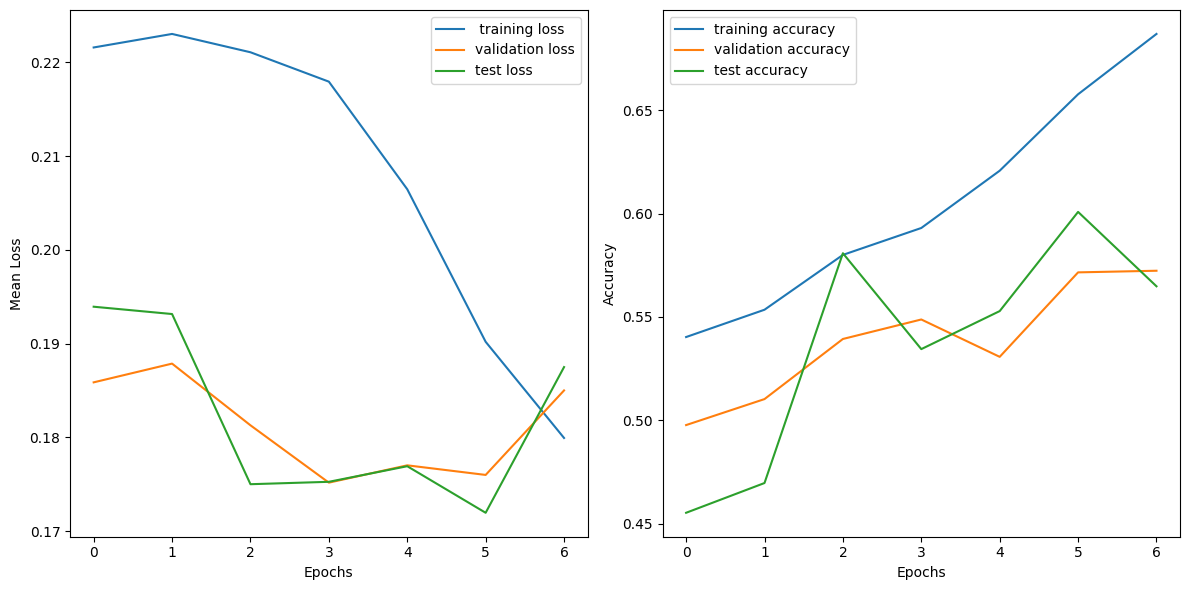

[1. 1. 0. ... 0. 1. 1.] [1. 0. 1. ... 1. 1. 1.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.54      0.67      0.60       609
         1.0       0.62      0.48      0.54       663

    accuracy                           0.57      1272
   macro avg       0.58      0.58      0.57      1272
weighted avg       0.58      0.57      0.57      1272

[0. 1. 1. ... 1. 1. 0.] [0. 1. 0. ... 1. 1. 0.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.50      0.66      0.57       549
         1.0       0.65      0.49      0.56       701

    accuracy                           0.56      1250
   macro avg       0.58      0.58      0.56      1250
weighted avg       0.59      0.56      0.56      1250



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class CNNModel(nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, output_size):
    super(CNNModel, self).__init__()
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    filter_sizes = [2,3,4]
    self.convs = nn.ModuleList([
      nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=128, kernel_size=fs),
        nn.ReLU(),
        nn.Dropout(p=0.8)
      ) for fs in filter_sizes
    ])
    self.fc = nn.Linear(128*3, output_size)

  def forward(self, x, POS, Meta, val = False):
    x = self.word_embeddings(x)
    x = x.permute(0, 2, 1)
    x = [nn.functional.relu(conv(x)) for conv in self.convs]
    x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x]
    x = torch.cat(x, 1)
    x = self.fc(x)
    return x


# Instantiate the model
input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
output_size = 6
model = CNNModel(input_size, input_size_POS, input_size_Meta, embedding_dim, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 7

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

[1] 	 train loss:0.370 	 train accuracy: 0.553 	 count: 10138
[1] 	 val loss:0.372 	 val accuracy: 0.521 	 count: 1272
[1] 	 test loss:0.369 	 test accuracy: 0.561 	 count: 1250

[2] 	 train loss:0.368 	 train accuracy: 0.559 	 count: 10138
[2] 	 val loss:0.377 	 val accuracy: 0.521 	 count: 1272
[2] 	 test loss:0.369 	 test accuracy: 0.561 	 count: 1250

[3] 	 train loss:0.366 	 train accuracy: 0.567 	 count: 10138
[3] 	 val loss:0.366 	 val accuracy: 0.566 	 count: 1272
[3] 	 test loss:0.365 	 test accuracy: 0.574 	 count: 1250

[4] 	 train loss:0.347 	 train accuracy: 0.656 	 count: 10138
[4] 	 val loss:0.367 	 val accuracy: 0.564 	 count: 1272
[4] 	 test loss:0.363 	 test accuracy: 0.582 	 count: 1250

[5] 	 train loss:0.329 	 train accuracy: 0.728 	 count: 10138
[5] 	 val loss:0.367 	 val accuracy: 0.569 	 count: 1272
[5] 	 test loss:0.366 	 test accuracy: 0.578 	 count: 1250

[6] 	 train loss:0.319 	 train accuracy: 0.766 	 count: 10138
[6] 	 val loss:0.367 	 val accuracy: 0.571 

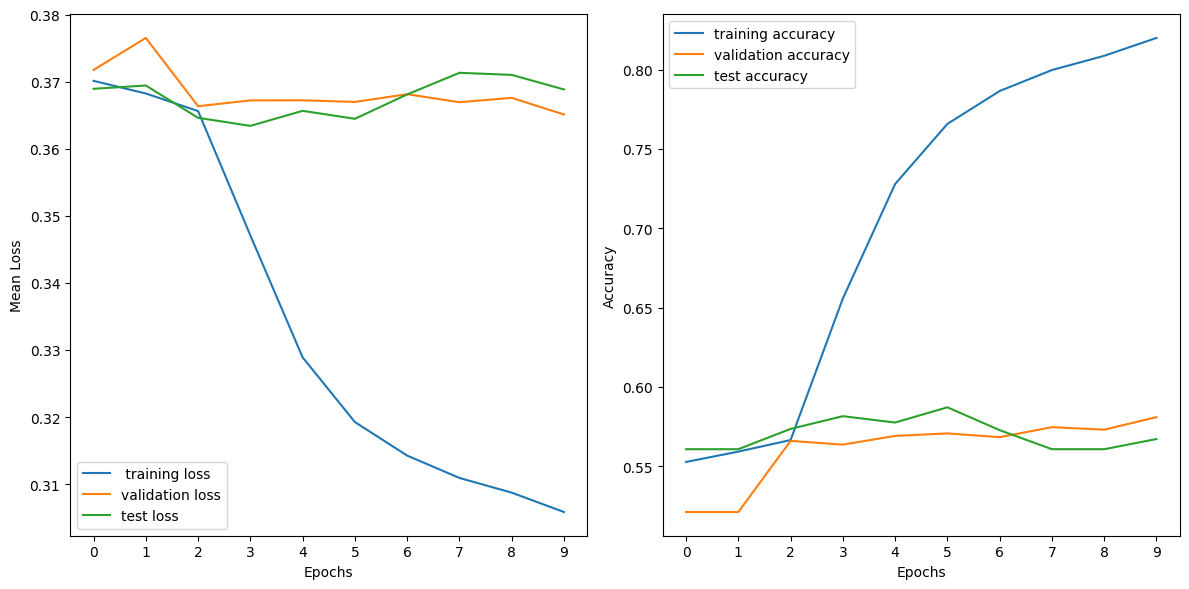

[0. 1. 0. ... 0. 0. 0.] [1. 1. 0. ... 1. 0. 0.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.57      0.53      0.55       609
         1.0       0.59      0.63      0.61       663

    accuracy                           0.58      1272
   macro avg       0.58      0.58      0.58      1272
weighted avg       0.58      0.58      0.58      1272



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[0. 0. 1. ... 0. 0. 1.] [1. 0. 0. ... 1. 0. 0.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.51      0.48      0.49       549
         1.0       0.61      0.64      0.62       701

    accuracy                           0.57      1250
   macro avg       0.56      0.56      0.56      1250
weighted avg       0.56      0.57      0.57      1250



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTMModel(nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

    self.fc1 = nn.Linear(hidden_size, 100)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(100, 6)
    self.softmax = nn.Softmax()


  def forward(self, x, POS, Meta, val = False):
    x = self.word_embeddings(x)
    out, (h,s) = self.lstm(x)

    out = self.dropout1(nn.functional.relu(self.fc1(out[:,-1,:])))
    out = self.fc2(out)
    return self.softmax(out)

# Instantiate the model
input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6
model = LSTMModel(input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-9-0b789b50fd09>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1] 	 train loss:0.369 	 train accuracy: 0.558 	 count: 10138
[1] 	 val loss:0.371 	 val accuracy: 0.523 	 count: 1272
[1] 	 test loss:0.366 	 test accuracy: 0.561 	 count: 1250

[2] 	 train loss:0.355 	 train accuracy: 0.617 	 count: 10138
[2] 	 val loss:0.359 	 val accuracy: 0.602 	 count: 1272
[2] 	 test loss:0.358 	 test accuracy: 0.606 	 count: 1250

[3] 	 train loss:0.332 	 train accuracy: 0.717 	 count: 10138
[3] 	 val loss:0.359 	 val accuracy: 0.604 	 count: 1272
[3] 	 test loss:0.361 	 test accuracy: 0.593 	 count: 1250

[4] 	 train loss:0.317 	 train accuracy: 0.778 	 count: 10138
[4] 	 val loss:0.359 	 val accuracy: 0.598 	 count: 1272
[4] 	 test loss:0.364 	 test accuracy: 0.580 	 count: 1250

[0.36886680848171877, 0.35470997295945933, 0.3315275923743429, 0.31683000433630765] [array(0.5578023, dtype=float32), array(0.616887, dtype=float32), array(0.7172026, dtype=float32), array(0.7779641, dtype=float32)]
[0.3710750611323231, 0.3591170829234633, 0.3587688485968788, 0.35860

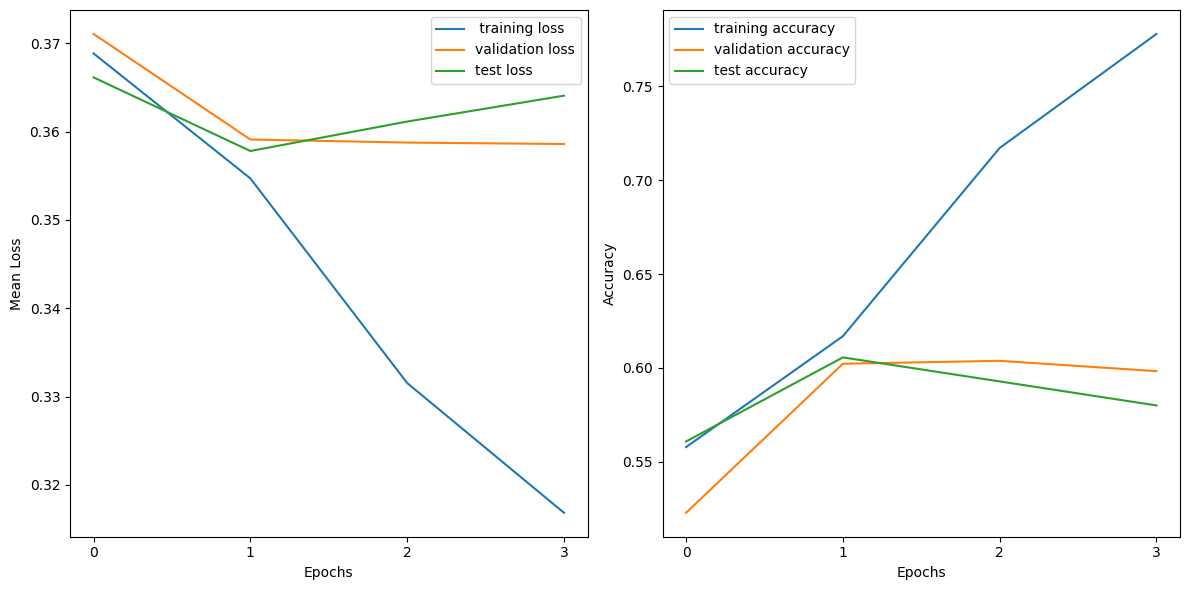

[0. 1. 0. ... 0. 1. 0.] [0. 0. 0. ... 0. 1. 0.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.61      0.45      0.52       609
         1.0       0.59      0.74      0.66       663

    accuracy                           0.60      1272
   macro avg       0.60      0.59      0.59      1272
weighted avg       0.60      0.60      0.59      1272



<ipython-input-9-0b789b50fd09>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[0. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 1. 0. 1.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.53      0.40      0.46       549
         1.0       0.61      0.72      0.66       701

    accuracy                           0.58      1250
   macro avg       0.57      0.56      0.56      1250
weighted avg       0.57      0.58      0.57      1250



In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AttentionLSTM(torch.nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, lstm_hidden_size, output_size, batch_size):
    super(AttentionLSTM, self).__init__()
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)
    self.fc = nn.Linear(hidden_size, output_size)
    self.softmax = nn.Softmax()

  def forward(self, X, POS, Meta, val = False):
    embedded = self.word_embeddings(X)
    rnn_out, (h_n, c_n) = self.lstm(embedded)

    # attention
    merged_state = torch.cat([s for s in h_n],1).squeeze(0).unsqueeze(2)
    weights = torch.bmm(rnn_out, merged_state)
    weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
    attn_out = torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)

    out = self.fc(attn_out)
    return self.softmax(out)

input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6

hidden_dim = 128
batch_size = 4
vocab_size = len(vocab)

model = AttentionLSTM( input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, hidden_size // 2, output_size, batch_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-11-4abad382aca1>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1] 	 train loss:0.366 	 train accuracy: 0.573 	 count: 10138
[1] 	 val loss:0.361 	 val accuracy: 0.589 	 count: 1272
[1] 	 test loss:0.366 	 test accuracy: 0.568 	 count: 1250

[2] 	 train loss:0.351 	 train accuracy: 0.631 	 count: 10138
[2] 	 val loss:0.360 	 val accuracy: 0.596 	 count: 1272
[2] 	 test loss:0.355 	 test accuracy: 0.620 	 count: 1250

[3] 	 train loss:0.336 	 train accuracy: 0.696 	 count: 10138
[3] 	 val loss:0.356 	 val accuracy: 0.610 	 count: 1272
[3] 	 test loss:0.356 	 test accuracy: 0.620 	 count: 1250

[4] 	 train loss:0.327 	 train accuracy: 0.733 	 count: 10138
[4] 	 val loss:0.354 	 val accuracy: 0.629 	 count: 1272
[4] 	 test loss:0.358 	 test accuracy: 0.612 	 count: 1250

[0.3656221402775585, 0.3509783118898569, 0.33609912840660144, 0.32712530488915215] [array(0.5726968, dtype=float32), array(0.6309923, dtype=float32), array(0.6958966, dtype=float32), array(0.73337936, dtype=float32)]
[0.3606555769278568, 0.3596300627075651, 0.35621339495077076, 0.353

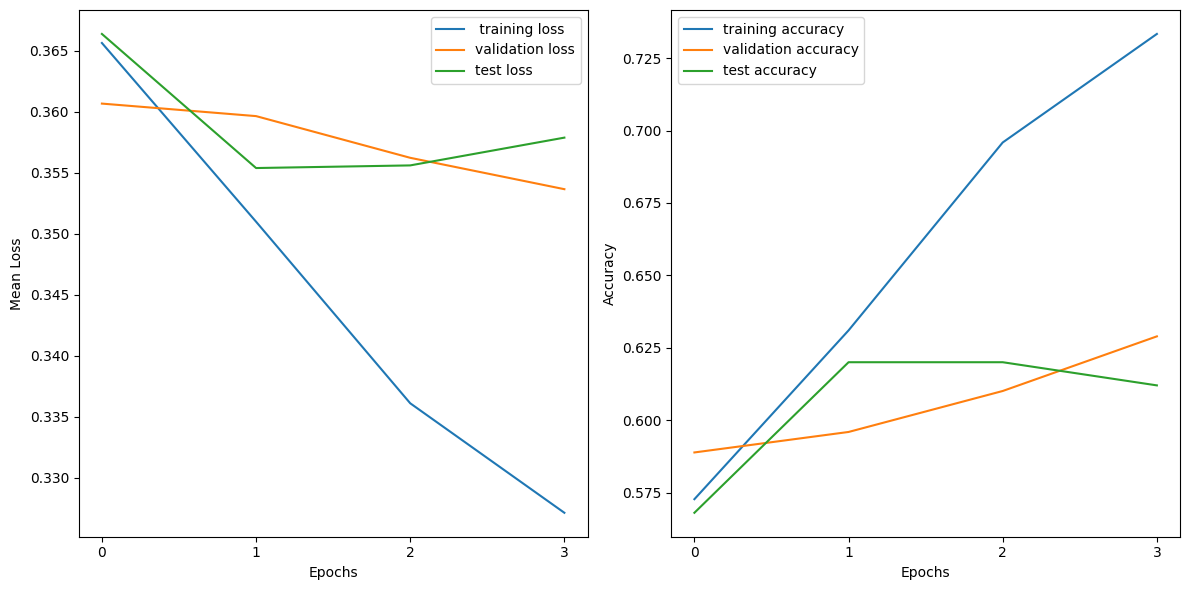

[1. 1. 1. ... 1. 1. 1.] [1. 1. 0. ... 0. 1. 1.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.68      0.42      0.52       609
         1.0       0.61      0.82      0.70       663

    accuracy                           0.63      1272
   macro avg       0.64      0.62      0.61      1272
weighted avg       0.64      0.63      0.61      1272



<ipython-input-11-4abad382aca1>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1. 1. 1. ... 1. 1. 0.] [0. 1. 0. ... 0. 1. 0.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.59      0.38      0.47       549
         1.0       0.62      0.79      0.70       701

    accuracy                           0.61      1250
   macro avg       0.61      0.59      0.58      1250
weighted avg       0.61      0.61      0.59      1250



In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HybridAttentionLSTM(torch.nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, lstm_hidden_size, output_size, batch_size):

    super(HybridAttentionLSTM, self).__init__()
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)

    self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)
    self.Meta_fc = nn.Linear(input_size_Meta, 64)
    self.Meta_dropout = nn.Dropout(p=0.5)

    self.POS_word_embeddings = nn.Embedding(input_size_POS, embedding_dim)
    self.POS_lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)

    self.fc1 = nn.Linear(hidden_size*2 + 64, 100)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(100, output_size)
    self.softmax = nn.Softmax()

  def forward(self, X, POS, Meta, val = False):
    embedded = self.word_embeddings(X)
    rnn_out, (h_n, c_n) = self.lstm(embedded)

    embedded_POS = self.POS_word_embeddings(POS)
    rnn_POS, (h_POS,s_POS) = self.POS_lstm(embedded_POS)

    rnn_out = torch.cat([rnn_out,rnn_POS],dim = 2)
    h_n = torch.cat([h_n, h_POS], dim = 0)

    # attention
    merged_state = torch.cat([s for s in h_n],1).squeeze(0).unsqueeze(2)
    weights = torch.bmm(rnn_out, merged_state)
    weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
    attn_out = torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)

    out_meta = self.Meta_dropout(nn.functional.relu(self.Meta_fc(Meta)))
    out = torch.cat([attn_out,out_meta],dim=1)

    out = self.dropout1(nn.functional.relu(self.fc1(out)))
    out = self.fc2(out)
    return self.softmax(out)

input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6

hidden_dim = 128
batch_size = 4
vocab_size = len(vocab)


model = HybridAttentionLSTM( input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, hidden_size // 2, output_size, batch_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)